In [16]:
!pip install lightgbm

  Using cached lightgbm-3.3.5-py3-none-win_amd64.whl (1.0 MB)


In [73]:
import pandas as pd
import dill
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, mean_squared_error
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
import seaborn

#working with text
from sklearn.feature_extraction.text import TfidfVectorizer

#normalizing data
from sklearn.preprocessing import StandardScaler

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score,recall_score

#imputer
from sklearn.impute import SimpleImputer

import sklearn.datasets

In [105]:
df = pd.read_csv('Cancer_Data.csv')
df.head(3)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38           122.8     1001.0   
1    842517         M        20.57         17.77           132.9     1326.0   
2  84300903         M        19.69         21.25           130.0     1203.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33            184.6      2019.0            0.1622   
1  ...          23.41            158.8      1956.0            0.1238   
2  ...          25.53            152.5      1709.0            0.1444   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  

[3 rows x 33 columns]

In [106]:
df.drop(columns='Unnamed: 32', inplace=True)

In [107]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

C:\Users\Андрей\AppData\Local\Temp\ipykernel_3224\3583242889.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


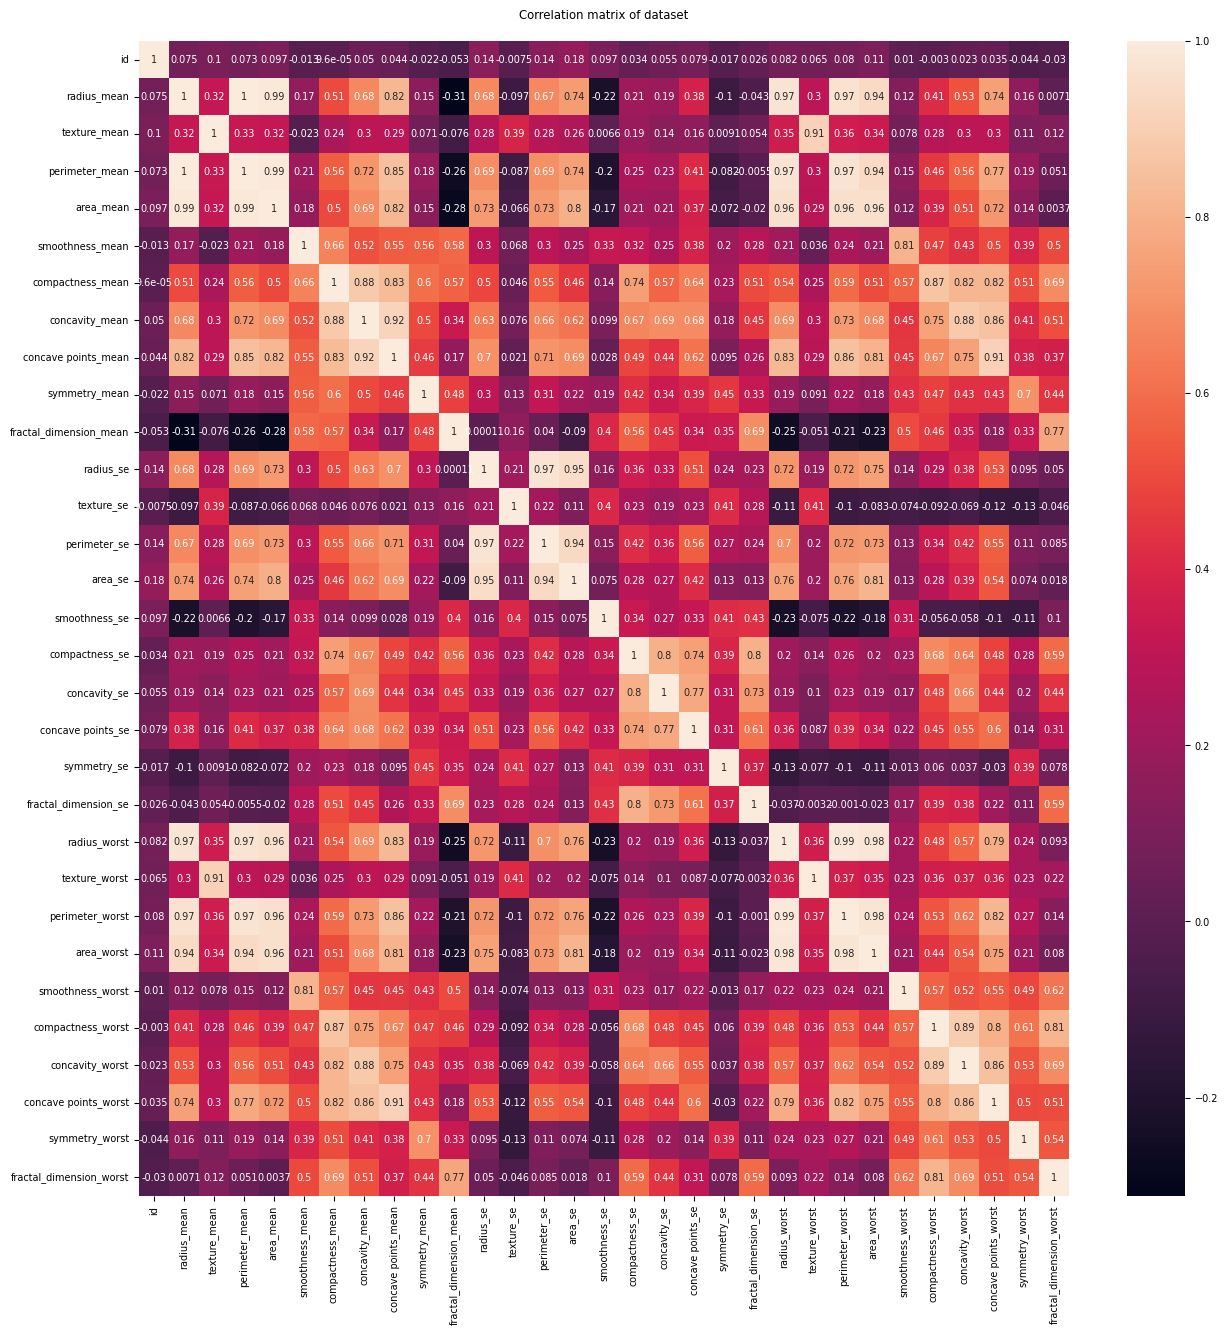

In [47]:
fig = plt.figure(figsize=((15, 15)))
correlation = df.corr()
heatmap = seaborn.heatmap(correlation, annot = True)
heatmap.set(title = "Correlation matrix of dataset\n")  
plt.show()

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [109]:
target = df['diagnosis']

In [110]:
target = target.map({'M': 1, "B": 0})

In [111]:
df.drop(columns='diagnosis', inplace=True)

In [112]:
plt.rcParams.update({'font.size': 7})

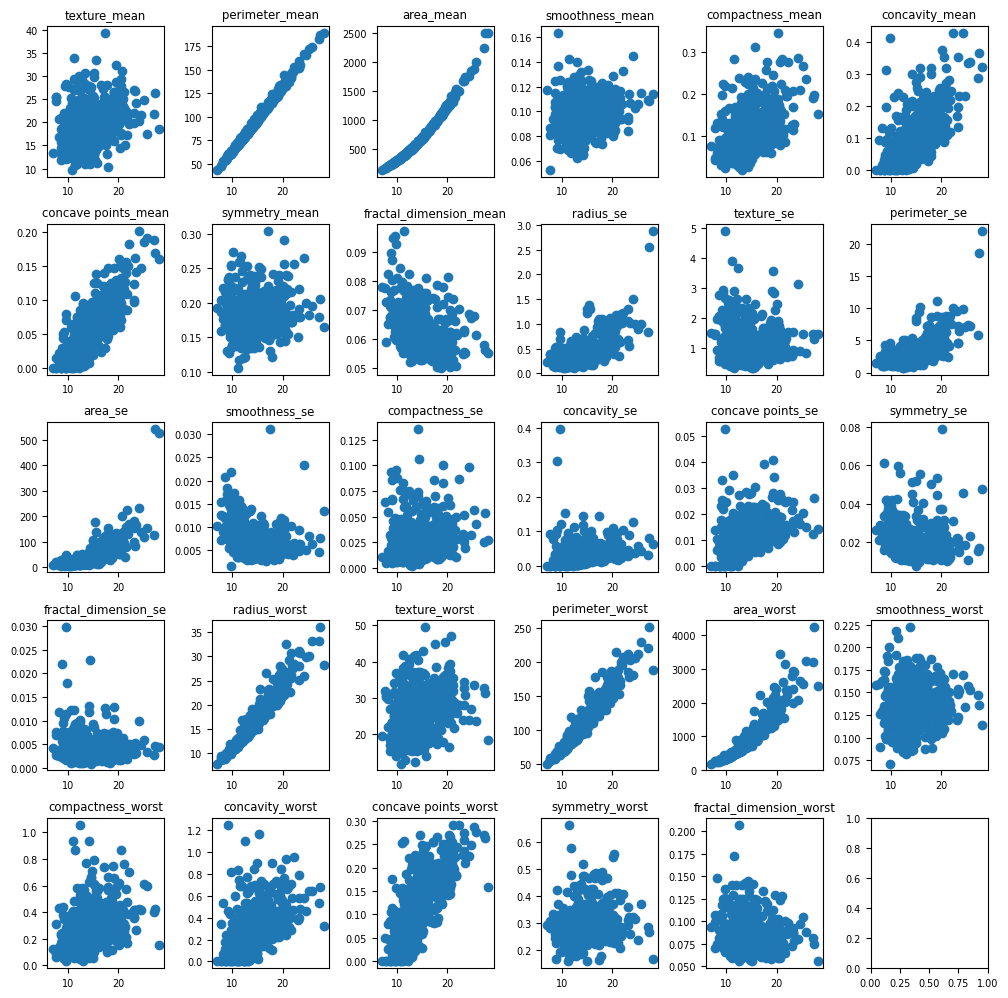

In [15]:
fig, _ = plt.subplots(5, 6)
axes = fig.get_axes()
fig.set_size_inches((10,10))
columns = df.drop(columns=['id', 'radius_mean']).columns
for i, feature in enumerate(columns):    
    axes[i].scatter(df['radius_mean'], df[feature])
    axes[i].set_title(feature)   
fig.tight_layout()

In [116]:
# соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.loc[:, self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


class OHEEncoderBin(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        B = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        self.columns = B[:1]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
    
        return X[self.columns]  


class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p=2):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        B = [self.key + str(i) for i in range(1, self.p)]
        self.columns = B + ['log']
        return self

    def transform(self, X):
        Xp = X.values.reshape(-1,1)
        for i in range(2, self.p):
            Xp = np.hstack([Xp,(X.values.reshape(-1,1) ** i).astype(float)])

        Xp = np.hstack([Xp, np.log(X.values.reshape(-1,1) + 1).astype(float)])    
        B = pd.DataFrame(data = Xp, index = X.index, columns =[self.columns] )
        return B[self.columns]
    
class Division(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns = []
    
    def fit(self, X, y=None):
        self.columns = X.columns
        self.new_column = self.columns[0] + '/' + self.columns[1]
        return self
    
    def transform(self, X):
        X[self.new_column] = X.loc[:, self.columns[0]] / X.loc[:, self.columns[1]]
        X.drop(columns=self.columns, inplace=True)
        return X.to_numpy()

In [82]:
numeric_features = ['texture_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'texture_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
division_features = [
    ['radius_mean', 'perimeter_mean'],
    ['radius_mean', 'perimeter_worst'],
    ['radius_mean', 'area_worst'],
    ['radius_mean', 'area_mean'],
    ['radius_mean', 'radius_worst'],
]test

In [132]:
final_transformers = []

for feat in numeric_features:
    transformer = Pipeline([
        ('selector', NumberSelector(key=feat)),
        ('scaler', MinMaxScaler()),
    ])
    final_transformers.append((feat, transformer))
for feat_pairs in division_features:
    transformer = Pipeline([
        ('selector', FeatureSelector(column=feat_pairs)),
        ('division', Division()),
    ])
    final_transformers.append(('/'.join(feat_pairs) ,transformer))

feats = FeatureUnion(final_transformers)
model = Pipeline([
    ('feats', feats),
    ('classifier', LGBMClassifier(boosting_type='gbdt',
                                            objective= 'regression',
                                            metric= 'l1',
                                            num_leaves=31,
                                            learning_rate= 0.05,
                                            feature_fraction= 0.9,
                                            bagging_fraction= 0.8,
                                            bagging_freq= 5,
                                            verbose= 0))
])

In [133]:
model

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('texture_mean',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='texture_mean')),
                                                                 ('scaler',
                                                                  MinMaxScaler())])),
                                                ('smoothness_mean',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='smoothness_mean')),
                                                                 ('scaler',
                                                                  MinMaxScaler())])),
                                                ('compactness_mean',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='co...
                                                                  FeatureSelector(column=['radius_mean',
                                                                                          'area_mean'])),
                                                                 ('division',
                                                                  Division())])),
                                                ('radius_mean/radius_worst',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column=['radius_mean',
                                                                                          'radius_worst'])),
                                                                 ('division',
                                                                  Division())]))])),
                ('classifier',
                 LGBMClassifier(bagging_fraction=0.8, bagging_freq=5,
                                feature_fraction=0.9, learning_rate=0.05,
                                metric='l1', objective='regression',
                                verbose=0))])

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['id']),target, test_size=0.3, random_state=42)

In [120]:
X_train

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
149       13.740         17.91           88.12      585.0          0.07944   
124       13.370         16.39           86.10      553.5          0.07115   
421       14.690         13.98           98.22      656.1          0.10310   
195       12.910         16.33           82.53      516.4          0.07941   
545       13.620         23.23           87.19      573.2          0.09246   
..           ...           ...             ...        ...              ...   
71         8.888         14.64           58.79      244.0          0.09783   
106       11.640         18.33           75.17      412.5          0.11420   
270       14.290         16.82           90.30      632.6          0.06429   
435       13.980         19.62           91.12      599.5          0.10600   
102       12.180         20.52           77.22      458.7          0.08013   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
149           0.06376         0.02881              0.01329         0.1473   
124           0.07325         0.08092              0.02800         0.1422   
421           0.18360         0.14500              0.06300         0.2086   
195           0.05366         0.03873              0.02377         0.1829   
545           0.06747         0.02974              0.02443         0.1664   
..                ...             ...                  ...            ...   
71            0.15310         0.08606              0.02872         0.1902   
106           0.10170         0.07070              0.03485         0.1801   
270           0.02675         0.00725              0.00625         0.1508   
435           0.11330         0.11260              0.06463         0.1669   
102           0.04038         0.02383              0.01770         0.1739   

     fractal_dimension_mean  ...  radius_worst  texture_worst  \
149                 0.05580  ...        15.340          22.46   
124                 0.05823  ...        14.260          22.75   
421                 0.07406  ...        16.460          18.34   
195                 0.05667  ...        13.880          22.00   
545                 0.05801  ...        15.350          29.09   
..                      ...  ...           ...            ...   
71                  0.08980  ...         9.733          15.67   
106                 0.06520  ...        13.140          29.26   
270                 0.05376  ...        14.910          20.65   
435                 0.06544  ...        17.040          30.80   
102                 0.05677  ...        13.340          32.84   

     perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
149            97.19       725.9           0.09711            0.18240   
124            91.99       632.1           0.10250            0.25310   
421           114.10       809.2           0.13120            0.36350   
195            90.81       600.6           0.10970            0.15060   
545            97.58       729.8           0.12160            0.15170   
..               ...         ...               ...                ...   
71             62.56       284.4           0.12070            0.24360   
106            85.51       521.7           0.16880            0.26600   
270            94.44       684.6           0.08567            0.05036   
435           113.90       869.3           0.16130            0.35680   
102            84.58       547.8           0.11230            0.08862   

     concavity_worst  concave points_worst  symmetry_worst  \
149          0.15640               0.06019          0.2350   
124          0.33080               0.08978          0.2048   
421          0.32190               0.11080          0.2827   
195          0.17640               0.08235          0.3024   
545          0.10490               0.07174          0.2642   
..               ...                   ...             ...   
71           0.14340               0.04786         

In [134]:
light_gbm_model = model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [138]:
y_preds = model.predict_proba(X_test)[:, 1]

In [139]:
precision, recall, thresholds = precision_recall_curve(y_test, y_preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.6249811557828746, F-Score=0.968, Precision=0.984, Recall=0.952


In [28]:
import pandas as pd
import dill

In [141]:
with open("lightgbm_pipeline.dill", "wb") as f:
    dill.dump(light_gbm_model, f)

In [26]:
#from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify
import pandas as pd

In [27]:
# Пробный запуск Flask

app = Flask(__name__)
#run_with_ngrok(app)  # Start ngrok when app is run

@app.route("/a")
def hello():
    return "Hello World!"

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [23/Apr/2023 17:35:37] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [23/Apr/2023 17:35:37] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/Apr/2023 17:35:42] "GET /r HTTP/1.1" 404 -
127.0.0.1 - - [23/Apr/2023 17:35:49] "GET /a HTTP/1.1" 200 -


### **Создаем сервис для обработки запросов к модели**

In [142]:
# Загружаем обученные модели
with open('lightgbm_pipeline.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [40]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [157]:
# Обработчики и запуск Flask
app = Flask(__name__)
#run_with_ngrok(app)  # Start ngrok when app is run


@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


Запустить сервис и не глушить его, пока работаем 

In [153]:
# Обработчики и запуск Flask
app = Flask(__name__)
#run_with_ngrok(app)  # Start ngrok when app is run


@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

@app.route('/predict', methods=['POST'])
def predict():
    data = {"success": False}

    # ensure an image was properly uploaded to our endpoint
    request_json = request.get_json()
    
#     if request_json["description"]:
#         description = request_json['description']
    
#     if request_json["company_profile"]:
#         company_profile = request_json['company_profile']
                
#     if request_json["benefits"]:
#         benefits = request_json['benefits']

    preds = model.predict_proba(pd.read_json(request_json))
    data["predictions"] = preds[:, 1][0]
#     data["description"] = description
        # indicate that the request was a success
    data["success"] = True
    print('OK')

        # return the data dictionary as a JSON response
    return jsonify(data)


if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


Сторона клиента: https://colab.research.google.com/drive/1UK_ToiHKZaZhKt8nZmAlWDIb0Nhz_c5X

Тестовый клиент

In [ ]:
# Пример данных
description_data, company_profile_data, benefits_data = ( 
    "Stylect is a dynamic startup that helps helps women discover and buy shoes. We’re a small team based in London that has previously worked at Google, Techstars, Pixelmator and Rocket Internet.We place a high premium on simplicity no matter what we’re working on (i.e. design, programming, marketing). We’re also a team that ships fast. We built version 1 of our app in a week, the next release (built in a month) was featured in the Apple Appstore Italy as a best new fashion app. Fast release cycles are challenging, but also very fun - which is why we love them.\xa0As we’ve grown, the projects that we’re working on have grown both in scale and in technical complexity. \xa0Stylect is looking for someone who can help us improve our backend which gathers product data; analyses/categorizes it; and shows it to thousands of users daily. Each step in the process has unique challenges that demands a strong technical background.",
    "ustwo offers you the opportunity to be yourself, whilst delivering the best work on the planet for some of the biggest and most innovative brands. A culture thriving on collaboration underpins what is an amazing work smart/ live well environment.We genuinely care about the work that we deliver and the people who help make it all possible. We only invest in projects, people and practices that we believe in, to ensure we remain excited about every opportunity.",
    "We are negotiable on salary and there is the potential for equity for the right candidate."
)

body = {
        'description': description_data, 
        'company_profile': company_profile_data,
        'benefits': benefits_data
        }

In [149]:
body = X_test.iloc[0].to_json()

In [154]:
with app.test_client() as t:
    response = t.post('/predict', json=body)
    json_data = response.get_json()

json_data

[2023-04-24 21:47:08,294] ERROR in app: Exception on /predict [POST]
Traceback (most recent call last):
  File "D:\Install\Anaconda3\lib\site-packages\flask\app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "D:\Install\Anaconda3\lib\site-packages\flask\app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "D:\Install\Anaconda3\lib\site-packages\flask\app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "D:\Install\Anaconda3\lib\site-packages\flask\app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "C:\Users\Андрей\AppData\Local\Temp\ipykernel_3224\3713736766.py", line 26, in predict
    preds = model.predict_proba(pd.read_json(request_json))
  File "D:\Install\Anaconda3\lib\site-packages\pandas\util\_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "D:\Install\Anaconda3\lib\site-package